In [4]:
# Cell 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import xml.etree.ElementTree as ET
import torch
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import os
import torch.nn as nn

cuda_available = torch.cuda.is_available()

print(f"CUDA Available: {cuda_available}")

if cuda_available:
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available. PyTorch will use the CPU.")

CUDA Available: True
GPU 0: NVIDIA GeForce RTX 3080


In [5]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.images = []
        self.labels = []
        self.no_annotation_count = 0

        images_dir = os.path.join(root_dir, "raw-images")
        annotations_dir = os.path.join(root_dir, "annotations")

        for subfolder in os.listdir(images_dir):
            subfolder_images_dir = os.path.join(images_dir, subfolder)
            subfolder_annotations_dir = os.path.join(annotations_dir, subfolder)

            if not os.path.isdir(subfolder_annotations_dir):
                continue

            image_files = [f for f in os.listdir(subfolder_images_dir) if f.endswith(".jpg") or f.endswith(".png")]
            
            # Exclude files with "rgb" in their name
            image_files = [f for f in image_files if "rgb" not in f.lower()]

            image_files.sort()

            num_images = len(image_files)
            if split == "train":
                image_files = image_files[:int(0.7 * num_images)]
            elif split == "val":
                image_files = image_files[int(0.7 * num_images):int(0.9 * num_images)]
            elif split == "test":
                image_files = image_files[int(0.9 * num_images):]
            else:
                raise ValueError(f"Invalid split: {split}")

            for filename in image_files:
                image_path = os.path.join(subfolder_images_dir, filename)
                annotation_path = os.path.join(subfolder_annotations_dir, os.path.splitext(filename)[0] + ".xml")

                if os.path.exists(annotation_path):
                    tree = ET.parse(annotation_path)
                    root = tree.getroot()
                    label = root.find("object").find("name").text

                    self.images.append(image_path)
                    self.labels.append(label)
                else:
                    self.no_annotation_count += 1

        print(f"Number of images: {len(self.images)}")
        print(f"Number of annotations: {len(self.labels)}")
        print(f"Number of images without annotations: {self.no_annotation_count}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = self.images[index]
        image = Image.open(image_path).convert("RGB")  # Convert grayscale to RGB
        label = self.labels[index]
    
        if self.transform:
            image = self.transform(image)
    
        return image, label

In [6]:
# Cell 3: Dataset Preparation
dataset_path = "dataset"
split = "train"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = CustomDataset(dataset_path, split, transform)

class_labels = list(set(dataset.labels))
class_to_idx = {label: idx for idx, label in enumerate(class_labels)}
print("Class labels:", class_to_idx)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Number of images: 630
Number of annotations: 630
Number of images without annotations: 458
Class labels: {'vehicle': 0, 'lightTruck': 1, 'largeCar': 2, 'smallCar': 3, 'heavyTruck': 4}


In [7]:
# Cell 4: Model Definition
num_classes = len(class_labels)

classification_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_features = classification_model.fc.in_features
classification_model.fc = nn.Linear(num_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classification_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
# Cell 5: Image Classification Training
classification_criterion = nn.CrossEntropyLoss()
classification_optimizer = torch.optim.Adam(classification_model.parameters(), lr=0.001)

num_epochs = 30

for epoch in range(num_epochs):
    classification_model.train()
    
    running_loss = 0.0
    
    for images, labels in dataloader:
        images = images.to(device)
        labels = [class_to_idx[label] for label in labels]
        labels = torch.tensor(labels).to(device)
        
        outputs = classification_model(images)
        loss = classification_criterion(outputs, labels)
        
        classification_optimizer.zero_grad()
        loss.backward()
        classification_optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Classification Loss: {epoch_loss:.4f}")

torch.save(classification_model.state_dict(), "classification_model.pth")

classification_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloader:
        images = images.to(device)
        labels = [class_to_idx[label] for label in labels]
        labels = torch.tensor(labels).to(device)
        
        outputs = classification_model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Classification Accuracy: {accuracy:.2f}%")

Epoch [1/30], Classification Loss: 1.2454
Epoch [2/30], Classification Loss: 1.0315
Epoch [3/30], Classification Loss: 0.7670
Epoch [4/30], Classification Loss: 0.6562
Epoch [5/30], Classification Loss: 0.4500
Epoch [6/30], Classification Loss: 0.3984
Epoch [7/30], Classification Loss: 0.3797
Epoch [8/30], Classification Loss: 0.2806
Epoch [9/30], Classification Loss: 0.2931
Epoch [10/30], Classification Loss: 0.2005
Epoch [11/30], Classification Loss: 0.1610
Epoch [12/30], Classification Loss: 0.0860
Epoch [13/30], Classification Loss: 0.0868
Epoch [14/30], Classification Loss: 0.0611
Epoch [15/30], Classification Loss: 0.0527
Epoch [16/30], Classification Loss: 0.1309
Epoch [17/30], Classification Loss: 0.1940
Epoch [18/30], Classification Loss: 0.1030
Epoch [19/30], Classification Loss: 0.0644
Epoch [20/30], Classification Loss: 0.0603
Epoch [21/30], Classification Loss: 0.0337
Epoch [22/30], Classification Loss: 0.0154
Epoch [23/30], Classification Loss: 0.0109
Epoch [24/30], Class

In [9]:
# Cell 6: Test Image Classification Model

# Load the saved model
loaded_model = models.resnet50()
num_features = loaded_model.fc.in_features
loaded_model.fc = nn.Linear(num_features, num_classes)
loaded_model.load_state_dict(torch.load("classification_model.pth"))
loaded_model.to(device)
loaded_model.eval()

# Prepare the test dataset
test_dataset = CustomDataset(dataset_path, split="test", transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the model on the test dataset
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = [class_to_idx[label] for label in labels]
        labels = torch.tensor(labels).to(device)
        
        outputs = loaded_model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

Number of images: 69
Number of annotations: 69
Number of images without annotations: 89
Test Accuracy: 65.22%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of images: 69
Number of annotations: 69
Number of images without annotations: 89


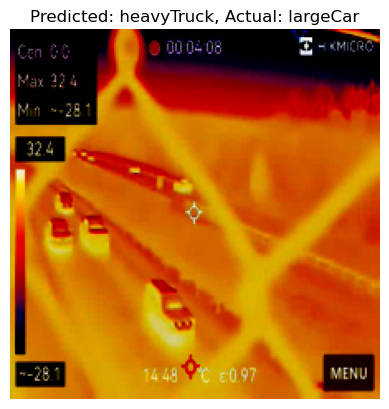

In [11]:
# Cell 7: Visualize Predictions

import matplotlib.pyplot as plt
import random

# Load the saved model
loaded_model = models.resnet50()
num_features = loaded_model.fc.in_features
loaded_model.fc = nn.Linear(num_features, num_classes)
loaded_model.load_state_dict(torch.load("classification_model.pth"))
loaded_model.to(device)
loaded_model.eval()

# Get a random image from the test dataset
test_dataset = CustomDataset(dataset_path, split="test", transform=transform)
random_index = random.randint(0, len(test_dataset) - 1)
image, label = test_dataset[random_index]

# Make a prediction
with torch.no_grad():
    image = image.unsqueeze(0).to(device)
    output = loaded_model(image)
    _, predicted = torch.max(output.data, 1)
    predicted_label = class_labels[predicted.item()]

# Remove the extra dimension from the image tensor
image = image.squeeze(0)

# Visualize the image and predicted label
plt.imshow(image.cpu().permute(1, 2, 0))
plt.title(f"Predicted: {predicted_label}, Actual: {label}")
plt.axis('off')
plt.show()

In [12]:
# Cell 8: Performance Metrics and Visualization

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Load the saved model
loaded_model = models.resnet50()
num_features = loaded_model.fc.in_features
loaded_model.fc = nn.Linear(num_features, num_classes)
loaded_model.load_state_dict(torch.load("classification_model.pth"))
loaded_model.to(device)
loaded_model.eval()

# Prepare the test dataset
test_dataset = CustomDataset(dataset_path, split="test", transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize lists to store predictions and true labels
predictions = []
true_labels = []

# Iterate over the test dataset
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = [class_to_idx[label] for label in labels]
        labels = torch.tensor(labels).to(device)
        
        outputs = loaded_model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate performance metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Binarize the labels for each class
true_labels_binary = label_binarize(true_labels, classes=range(num_classes))
predictions_binary = label_binarize(predictions, classes=range(num_classes))

# Calculate precision-recall curve and average precision score for each class
precision_curves = []
recall_curves = []
avg_precisions = []

for i in range(num_classes):
    precision_curve, recall_curve, _ = precision_recall_curve(true_labels_binary[:, i], predictions_binary[:, i])
    precision_curves.append(precision_curve)
    recall_curves.append(recall_curve)
    avg_precision = average_precision_score(true_labels_binary[:, i], predictions_binary[:, i])
    avg_precisions.append(avg_precision)

# Calculate the mean average precision score across all classes
mean_avg_precision = np.mean(avg_precisions)

# Visualize the precision-recall curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(recall_curves[i], precision_curves[i], label=f'Class {i}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

print(f"Mean Average Precision: {mean_avg_precision:.4f}")

Number of images: 69
Number of annotations: 69
Number of images without annotations: 89
Accuracy: 0.6522
Precision: 0.6917
Recall: 0.6522
F1 Score: 0.6409


ValueError: multiclass format is not supported